In [20]:
%matplotlib inline

import numpy as np
from scipy.stats import kde
import prettytable
import matplotlib.pyplot as plt
from matplotlib.mlab import bivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
import operator

## Kernel Density Estimation - The Parzen-window

![](https://raw.githubusercontent.com/rasbt/pattern_classification/master/Images/parzen_goal.png)


### 1. Introduction
The Parzen-window technique is a widely used non-parametric approach to estimate a probability density function $p(\pmb x)$ for a specific point $\pmb x$ from a sample $\pmb x_n$ that doesn't require any knowledge or assumption about the underying distribution.

A popular application of the Parzen-window technique is to estimate the class-conditional densities (or also often called 'likelihoods') $p(\pmb x \; | \omega_i)$ in a supervised pattern classification problem from the training dataset (where $\pmb x$ is a multi-dimensional sample that belongs to particular class $\omega_i$). Imagine that we are about to design a Bayes classifier for solving a statistical pattern classification task using Bayes's rule:  

$$P(\omega_i\; | \;\pmb x) = \frac{p(\pmb x \; | \; w_i) \cdot P(\omega_i)}{p(\pmb x)} 
 \\ \Rightarrow posterior \; probability = \frac{\; likelihood \; \cdot \; prior \; probability}{evidence}$$ 

If the parameters of the the *class-conditional densities* (also called *likelihoods*) are known, it is pretty easy to design the classifier. However, it becomes much more challenging, if we don't don't have prior knowledge about the underlying parameters that define the model of our data. Imagine we are about to design a classifier for a pattern classification task where the parameters of the underlying sample distribution are not known. Therefore, we wouldn't need the knowledge about the whole range of the distribution; it would be sufficient to know the probability of the particular point, which we want to classify, in order to make the decision. And here we are going to see how we can estimate this probability from the training sample. However, the only problem of this approach would be that we would seldom have exact values - if we consider the histogram of the frequencies for a arbitrary training dataset. Therefore, we define a certain *region* (i.e., the **Parzen-window**) around the particular value to make the estimate.

### 2. Defining the Region $R_n$
The basis of this approach is to count how many samples fall within a specified region $R_n$ (or "window" if you will). Our intuition tells us, that (based on the observation), the probability that one sample falls into this region is  

$$p(x) = \frac{\#\;of\;samples\;in\;R}{total \; samples}$$

To tackle this problem from a more mathematical standpoint to estimate "the probability of observing $k$ points out of $n$ in a Region $R$" we consider a binomial distribution  

$$p_k = \bigg[ \begin{array}{c} n \\ k \end{array}\bigg] \cdot p^k \cdot (1-p)^{n-k}$$ 
and make the assumption that in a binomial distribution, the probability peaks sharply at the mean, so that:

$$E[k] = n \cdot p \; \sim \; k = n \cdot p$$

And if we think of the probability of a continous variable, we know that it is defined as:

$$p(\pmb x) = \int_R dx = p(\pmb x) \cdot V$$,  
where $V$ is the volume of the region $R$,

and if we rearrange those terms, so that we arrive at the following equation, which we will use later:

$$\frac{k}{n} = p(\pmb x) \cdot V \\
\Rightarrow p(\pmb x) = \frac{k / n}{V}$$

This simple equation above (i.e, the "probability estimate") lets us caclulate the probability density of a point $\pmb x$ by counting how many points $k$ fall in a defined region (or volume).  


### 2.1. Two different approaches - fixed volume vs. fixed number of samples in a variable volume
Now, there are two possible approaches to estimate the densities at different points $\pmb x^*$.  

#### Case 1 - fixed volume:
For a particular number $n$ (= number of total points), we use volume $V$ of a fixed size and observe how many points $k$ fall into the region. In other words, we use the same volume to make an estimate at different regions.   
**The Parzen-window technique falls into this category!**

![](https://raw.githubusercontent.com/rasbt/pattern_classification/master/Images/mle_case1.png)

#### Case 2 - fixed $k$:
For a particular number $n$ (= number of total points), we use a fixed number $k$ (number of points that fall inside the region or volume) and adjust the volume accordingly.  
(**The k-nearest neighbor technique uses this approach, which will be discussed in a separate article.**)
![](https://raw.githubusercontent.com/rasbt/pattern_classification/master/Images/mle_case2.png)

### 2.2. Example 3D-hypercubes
To illustrate this with an example and a set of equations, let us assume this region $R_n$ is a hypercube.  
And the volume of this hypercube is defined by $V_n = {h_n}^d$, where $h_n$ is the length of the hypercube, and $d$ is the number of dimensions.  
For an 2D-hypercube with length 1, for example, this would be $V_1 = {1}^2$ and for a 3D hypercube $V_1 = {1}^3$, respectively.

So let us visualize such an simple example: a typical 3-dimensional unit hypercube ($h_1 = 1$) representing the region $R_1$, and 10 sample points, where 3 of them lie within the hypercube (red triangles), and the other 7 outside (blue dots).

**Note that using a hypercube would not be an ideal choice for a real application, but it certainly makes the implementations of the following steps a lot shorter and easier to follow**.

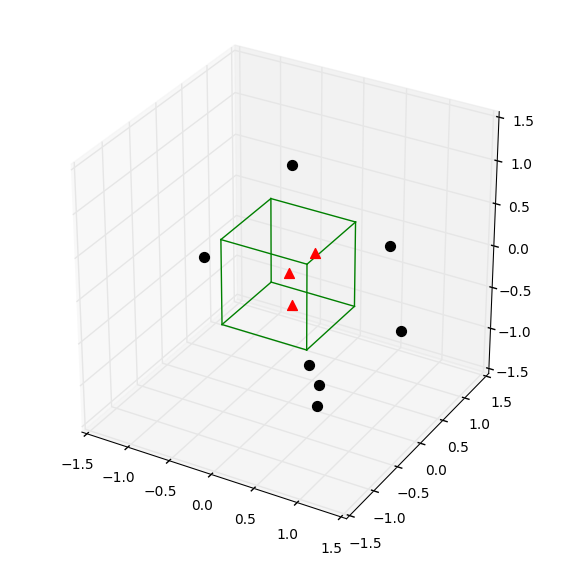

In [21]:

# Plot Points
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
ax.set_aspect("equal")

# samples within the cube
X_inside = np.array([[0,0,0],[0.2,0.2,0.2],[0.1, -0.1, -0.3]])

X_outside = np.array([[-1.2,0.3,-0.3],[0.8,-0.82,-0.9],[1, 0.6, -0.7],
                      [0.8,0.7,0.2],[0.7,-0.8,-0.45],[-0.3, 0.6, 0.9],
                      [0.7,-0.6,-0.8]])

for row in X_inside:
    ax.scatter(row[0], row[1], row[2], color="r", s=50, marker='^')

for row in X_outside:    
    ax.scatter(row[0], row[1], row[2], color="k", s=50)

# Plot Cube
h = [-0.5, 0.5]
for s, e in combinations(np.array(list(product(h,h,h))), 2):
    if np.sum(np.abs(s-e)) == h[1]-h[0]:
        ax.plot3D(*zip(s,e), color="g")
        
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

plt.show()



### 2.3. The *window function*

Once we visualized the region $R_1$ like above, it is easy and intuitive to count how many samples fall within this region, and how many lie outside. To approach this problem more mathematically, we would use the following equation to count the samples $k_n$ within this hypercube, where $\phi$ is our so-called *window function*:

$$\phi(\pmb u) = \Bigg[ \begin{array}{ll} 1 & \quad |u_j| \leq 1/2 \; ;\quad \quad j = 1, ..., d \\
0 & \quad otherwise \end{array} $$ 

for a hypercube of unit length 1 centered at the coordinate system's origin. What this function basically does is assigning a value 1 to a sample point if it lies within 1/2 of the edges of the hypercube, and 0 if lies outside (note that the evaluation is done for all dimensions of the sample point). If we extend on this concept, we can define a more general equation that applies to hypercubes of any length $h_n$ that are centered at $\pmb x$:  

$$k_n = \sum\limits_{i=1}^{n} \phi \bigg( \frac{\pmb x - \pmb x_i}{h_n} \bigg)$$ 

where $$\pmb u = \bigg( \frac{\pmb x - \pmb x_i}{h_n} \bigg)$$ 



### 2.3.1. Implementing the *window function*

In [22]:
def window_function(x_vec, unit_len=1):
    """
    Implementation of the window function. Returns 1 if 3x1-sample vector
    lies within a origin-centered hypercube, 0 otherwise.
    
    """
    for row in x_vec:
        if np.abs(row) > (unit_len/2):
            return 0
    return 1


### 2.3.2. Quantifying the sample points inside and outside $R_n$ (the 3D-hypercube)
Using the *window function* that we just implemented above, let us now quantify how many points actually lie inside and outside the hypercube.

In [23]:
X_all = np.vstack((X_inside,X_outside))
assert(X_all.shape == (10,3))

k_n = 0
for row in X_all:
    k_n += window_function(row.reshape(3,1))
    
print('Points inside the hypercube:', k_n)
print('Points outside the hybercube:', len(X_all) - k_n)

Points inside the hypercube: 3
Points outside the hybercube: 7



### 2.4. Parzen-window estimation 

Based on the [window function](#window_function) that we defined in the section above, we can now formulate the Parzen-window estimation with a hypercube kernel as follows:

$$p_n(\pmb x) = \frac{1}{n} \sum\limits_{i=1}^{n} \frac{1}{h^d} \phi \bigg[ \frac{\pmb x - \pmb x_i}{h_n} \bigg]$$  

where   
$$h^d = V_n\quad$   and    $\quad\phi \bigg[ \frac{\pmb x - \pmb x_i}{h_n} \bigg] = k$$

And applying this to out unit-hypercube example above, for which 3 out of 10 samples fall inside the hypercube (region $R$), we can calculate the probability $p(\pmb x)$ that $\pmb x$ samples fall within region $R$ as follows:

$$p(\pmb x) = \frac{k/n}{h^d} = \frac{3/10}{1^3} = \frac{3}{10} = 0.3$$

### 2.5. Critical assumption: Convergence
One of the most critical assumptions why this technique works (i.e., the Parzen-window estimation, but the k-nearest neighbor technique as well), is that $p_n$ (where $n$ stands for the "number of samples", not "non-parametric" ;) ) converges to the true density $p(\pmb x)$ when we assume an infinite number of training samples, which was nicely shown by Emanuel Parzen in his [paper](http://ssg.mit.edu/cal/abs/2000_spring/np_dens/density-estimation/parzen62.pdf).

### 2.6. Critical parameters of the Parzen-window technique: window width and kernel
The two critical parameters in the Parzen-window techniques are

- 1) the window width  
- 2) the kernel

#### 1) window width:
Let us skip this part for now and [discuss and explore the question of choosing an appropriate window width later](#choosing_window)by using an hands-on example.  

#### 2) kernel:
Most commonly, either a hypercube or a Gaussian kernel is used for the window function. But how do we know which is better? It really depends on the training sample. In practice, the choice is often made by testing the derived pattern classifier to see which method leads to a better performance on the test data set.  
Intuitively, it would make sense to use a Gaussian kernel for a data set that follows a Gaussian distribution. **But remmeber, the whole purpose of the Parzen-window estimation is to estimate densities of a unknown distribution!** So, in practice we wouldn't know whether our data stems from a Gaussian distribution or not (otherwise we wouldn't need to estimate, but can use a parametric techniqe like MLE or Bayesian Estimation).  
If we would decide to use a Gaussian kernel instead of the hypercube, we can just simply swap the terms of the window function, which we defined above for the hypercube, by:

$$\frac{1}{(\sqrt{2 \pi})^d h_{n}^{d}} exp \; \bigg[ -\frac{1}{2} \bigg(\frac{\pmb x - \pmb x_i}{h_n} \bigg)^2 \bigg]$$

The Parzen-window estimation would then look like this:  

$$p_n(\pmb x) = \frac{1}{n} \sum\limits_{i=1}^{n} \frac{1}{h^d} \phi \Bigg[ \frac{1}{(\sqrt {2 \pi})^d h_{n}^{d}} exp \; \bigg[ -\frac{1}{2} \bigg(\frac{\pmb x - \pmb x_i}{h_n} \bigg)^2 \bigg] \Bigg]$$  

**mixing different kernels:**  
In some papers you will see, that the authors mixed hypercube and Gaussian kernels to estimate the densities at different regions. In practice, this might work very well, however, but note that in theory this would violate on of the underlying principles: that the density integrates to 1.

$$\lim\limits_{n \rightarrow \infty}{p_n(\pmb x)} = p(\pmb x)$$

A few other requirements are that at the limit the volume we choose for the Parzen-window becomes infinite small:  


$$\lim\limits_{n \rightarrow \infty}{V_n} = 0$$  


and the number of points $k_n$ in this region converges to:


$$\lim\limits_{n \rightarrow \infty}{k_n} = \infty$$   

from which we can conclude:

$$\lim\limits_{n \rightarrow \infty}{\frac{k_n}{n}} = 0$$   


### 2.7. Implementing the Parzen-window estimation
And again, let us go to the more interesting part and implement the code for the hypercube kernel:

In [24]:
def parzen_window_est(x_samples, h=1, center=[0,0,0]):
    '''
    Implementation of the Parzen-window estimation for hypercubes.
    
    Keyword arguments:
        x_samples: A 'n x d'-dimensional numpy array, where each sample
            is stored in a separate row.
        h: The length of the hypercube.
        center: The coordinate center of the hypercube
    
    Returns the probability density for observing k samples inside the hypercube.
    
    '''
    dimensions = x_samples.shape[1]

    assert (len(center) == dimensions), 'Number of center coordinates have to match sample dimensions'
    k = 0
    for x in x_samples:
        is_inside = 1
        for axis,center_point in zip(x, center):
            if np.abs(axis-center_point) > (h/2):
                is_inside = 0
        k += is_inside
    return (k / len(x_samples)) / (h**dimensions)

print('p(x) =', parzen_window_est(X_all, h=1))

p(x) = 0.3



## 3. Applying the Parzen-window approach to a random mutlivariate Gaussian dataset

Let us use an 2-dimensional dataset drawn from a multivariate Gaussian distribution to apply the Parzen-window technique for the density estimation.  


### 3.1. Generating 10000 random 2D-patterns from a Gaussian distribution

The general multivariate Gaussian probability density function (pdf) is defined as:  
$$p(\pmb x) = \frac{1}{(2\pi)^{d/2} \; |\Sigma|^{1/2}} exp \bigg[ -\frac{1}{2}(\pmb x - \pmb \mu)^t \Sigma^{-1}(\pmb x - \pmb \mu) \bigg]$$

And we will use the following parameters for drawing the random samples:
    
$$\pmb{\mu} = \bigg[ 
\begin{array}{c}
0\\
0\\
\end{array} \bigg]\;, \quad$     
$\Sigma = \bigg[ 
\begin{array}{cc}
\sigma_{11}^2 & \sigma_{12}^2\\
\sigma_{21}^2 & \sigma_{22}^2\\
\end{array} \bigg] \; = \bigg[ 
\begin{array}{cc}
1 & 0\\
0 & 1\\
\end{array} \bigg]$$

In [25]:
# Generate 10000 random 2D-patterns
mu_vec = np.array([0,0])
cov_mat = np.array([[1,0],[0,1]])
x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, 10000)

print(x_2Dgauss.shape)

(10000, 2)


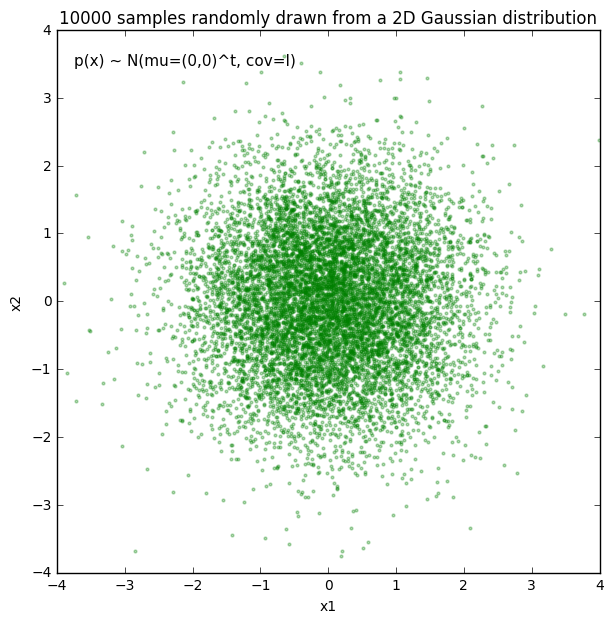

In [26]:
f, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x_2Dgauss[:,0], x_2Dgauss[:,1], marker='o', color='green', s=4, alpha=0.3)
plt.title('10000 samples randomly drawn from a 2D Gaussian distribution')
plt.ylabel('x2')
plt.xlabel('x1')
ftext = 'p(x) ~ N(mu=(0,0)^t, cov=I)'
plt.figtext(.15,.85, ftext, fontsize=11, ha='left')
plt.ylim([-4,4])
plt.xlim([-4,4])

plt.show()


## 3.2. The multivariate Gaussian density function

First, let us plot the multivariate Gaussian distribution (here: bivariate) in a 3D plot to get an better idea of the actual density distribution.

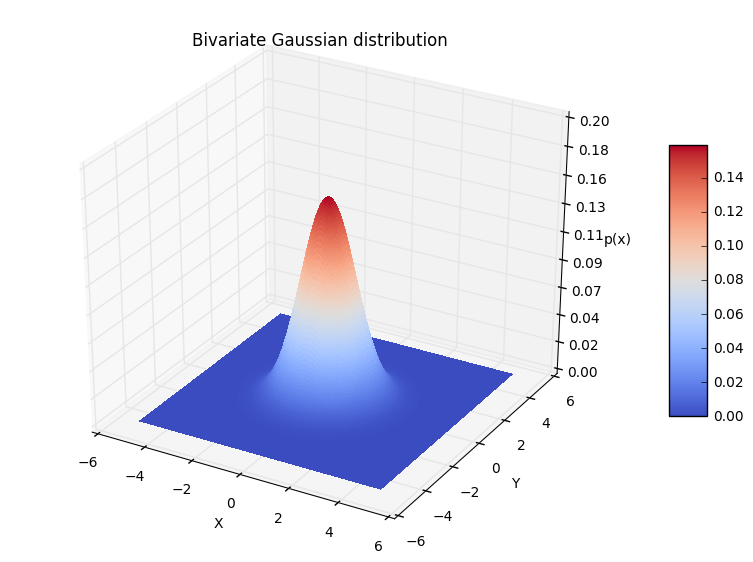

In [27]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
x = np.linspace(-5, 5, 200)
y = x
X,Y = np.meshgrid(x, y)
Z = bivariate_normal(X, Y)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm,
        linewidth=0, antialiased=False)

ax.set_zlim(0, 0.2)
ax.zaxis.set_major_locator(plt.LinearLocator(10))
ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('p(x)')

plt.title('Bivariate Gaussian distribution')

fig.colorbar(surf, shrink=0.5, aspect=7, cmap=plt.cm.coolwarm)

plt.show()

### 3.2.2 Implementing the code to calculate the multivariate Gaussian densities
To calculate the probabilities from the multivariate Gaussian density function and compare the results our estimate, let us implement it using the following equation:

$$p(\pmb x) = \frac{1}{(2\pi)^{d/2} \; |\Sigma|^{1/2}} exp \bigg[ -\frac{1}{2}(\pmb x - \pmb \mu)^t \Sigma^{-1}(\pmb x - \pmb \mu) \bigg]$$

Unfortunately, there is currently no Python library that provides this functionality. Good news is, that `scipy.stats.multivariate_normal.pdf()` will be implemented in the new release candidate of `scipy` (v. 0.14).

In [28]:
def pdf_multivariate_gauss(x, mu, cov):
    '''
    Caculate the multivariate normal density (pdf)
    
    Keyword arguments:
        x = numpy array of a "d x 1" sample vector
        mu = numpy array of a "d x 1" mean vector
        cov = "numpy array of a d x d" covariance matrix
    '''
    assert(mu.shape[0] > mu.shape[1]), 'mu must be a row vector'
    assert(x.shape[0] > x.shape[1]), 'x must be a row vector'
    assert(cov.shape[0] == cov.shape[1]), 'covariance matrix must be square'
    assert(mu.shape[0] == cov.shape[0]), 'cov_mat and mu_vec must have the same dimensions'
    assert(mu.shape[0] == x.shape[0]), 'mu and x must have the same dimensions'
    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).T.dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

### 3.2.2.1 Testing the multivariate Gaussian PDF implementation
Let us quickly confirm that the multivariate Gaussian, which we just implemented, works as expected by comparing 
it with the bivariate Gaussian from the `matplotlib.mlab` package.

In [29]:
x = np.array([[0],[0]])
mu  = np.array([[0],[0]])
cov = np.eye(2) 

mlab_gauss = bivariate_normal(x,x)
mlab_gauss = float(mlab_gauss[0]) # because mlab returns an np.array
impl_gauss = pdf_multivariate_gauss(x, mu, cov)

print('mlab_gauss:', mlab_gauss)
print('impl_gauss:', impl_gauss)
assert(mlab_gauss == impl_gauss), 'Implementations of the mult. Gaussian return different pdfs'

mlab_gauss: 0.15915494309189535
impl_gauss: 0.15915494309189535


### 3.2.3 Comparing the Parzen-window estimation to the actual densities

And finally, let us compare the densities that we estimate using our [implementation of the Parzen-window estimation](#implement_parzen_est) with the actual multivariate Gaussian densities.

But before we do the comparison, we have to ask ourselves one more question: Which window size should we choose (i.e., what should be the side length $h$ of our hypercube)? 

The window width is a function of the number of training samples,  

$$h_n \propto \frac{1}{\sqrt{n}}$$ 

But why $\sqrt{n}$, not just $n$?  
This is because the number of $k_n$ points within a window grows much smaller than the number of training samples, although  

$$\lim\limits_{n \rightarrow \infty}{k_n} = \infty$$   

we have:
$$ k < n$$


This is also one of the biggest drawbacks of the Parzen-window technique, since in practice, the number of training data is usually (too) small, which makes the choice of an 'optimal' window size difficult.  

**In practice, one would choose different window widths and analyze which one results in the best performance of the derived classifier.** The only guideline we have is that we assume that 'optimal' the window width shrinks with the number of training samples.


If we would choose a window width that is "too small", this would result in local spikes, and a window width that is "too big" would average over the whole distribution. Below, I try to illustrate it using a 1D-sample.  
![](https://raw.githubusercontent.com/rasbt/pattern_classification/master/Images/parzen_window_width.png)

### 3.2.3.1 Choosing an appropriate window size

For our example, we have the luxury of knowing the distribution of our data, so let us look at some possible window widths to see how it affects the density estimation for the center of the distribution (based on our [test](testing_gauss) in the section above, we would expect a value close to $p(\pmb x) = 0.1592\;$ ).

In [30]:
print('Predict p(x) at the center [0,0]: ')

print('h = 0.1 ---> p(x) =', parzen_window_est(x_2Dgauss, h=0.1, center=[0, 0]))
print('h = 0.3 ---> p(x) =',parzen_window_est(x_2Dgauss, h=0.3, center=[0, 0]))
print('h = 0.6 ---> p(x) =',parzen_window_est(x_2Dgauss, h=0.6, center=[0, 0]))
print('h = 1 ---> p(x) =',parzen_window_est(x_2Dgauss, h=1, center=[0, 0]))

Predict p(x) at the center [0,0]: 
h = 0.1 ---> p(x) = 0.13999999999999996
h = 0.3 ---> p(x) = 0.15333333333333335
h = 0.6 ---> p(x) = 0.16083333333333333
h = 1 ---> p(x) = 0.1444


This rough estimate above gives us some idea about a window size that would give us a quite reasonable estimate: A good value for $h$ should be somewhere around 0.6.  

But we can do better (maybe I should use a minimization algorithm here, but I think this example should illustrate the procedure sufficiently). So let us create 400 evenly spaced values between (0,1) for $h$ and see which gives us the estimate for the probability at the center of the distribution.

In [31]:
# generate a range of 400 window widths between 0 < h < 
h_range = np.linspace(0.001, 1, 400)

# calculate the actual density at the center [0, 0]
mu  = np.array([[0],[0]])
cov = np.eye(2)
actual_pdf_val = pdf_multivariate_gauss(np.array([[0],[0]]), mu, cov)

# get a list of the differnces (|estimate-actual|) for different window widths
parzen_estimates = [np.abs(parzen_window_est(x_2Dgauss, h=i, center=[0, 0])
                   - actual_pdf_val) for i in h_range]

# get the window width for which |estimate-actual| is closest to 0
min_index, min_value = min(enumerate(parzen_estimates), key=operator.itemgetter(1))

print('Optimal window width for this data set: ', h_range[min_index])

Optimal window width for this data set:  0.704556390977


### 3.2.3.2 Estimated vs. actual densities

Now, that we have a "appropriate" window width, let us compare the estimates to the actual densities for some example points.

In [32]:
import prettytable

p1 = parzen_window_est(x_2Dgauss, h=h_range[min_index], center=[0, 0])
p2 = parzen_window_est(x_2Dgauss, h=h_range[min_index], center=[0.5, 0.5])
p3 = parzen_window_est(x_2Dgauss, h=h_range[min_index], center=[0.3, 0.2])

mu  = np.array([[0],[0]])
cov = np.eye(2) 

a1 = pdf_multivariate_gauss(np.array([[0],[0]]), mu, cov)
a2 = pdf_multivariate_gauss(np.array([[0.5],[0.5]]), mu, cov)
a3 = pdf_multivariate_gauss(np.array([[0.3],[0.2]]), mu, cov)

results = prettytable.PrettyTable(["", "predicted", "actual"])
results.add_row(["p([0,0]^t",p1, a1])
results.add_row(["p([0.5,0.5]^t",p2, a2])
results.add_row(["p([0.3,0.2]^t",p3, a3])

print(results)

+---------------+----------------+---------------------+
|               |   predicted    |        actual       |
+---------------+----------------+---------------------+
|   p([0,0]^t   | 0.159145943715 | 0.15915494309189535 |
| p([0.5,0.5]^t | 0.113215215655 | 0.12394999430965298 |
| p([0.3,0.2]^t | 0.14041104148  | 0.14913891880709737 |
+---------------+----------------+---------------------+


As we can see in the table above, our prediction works quite well!

### 3.2.3.3 Plotting the estimated bivariate Gaussian densities
Last but not least, let us plot the densities that we'd predict using the Parzen-window technique with a hypercube!

In [ ]:
##############################################
### Predicted bivariate Gaussian densities ###
##############################################

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')

X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)
X,Y = np.meshgrid(X,Y)

Z = []
for i,j in zip(X.ravel(),Y.ravel()):
    Z.append(parzen_window_est(x_2Dgauss, h=h_range[min_index], center=[i, j]))

Z = np.asarray(Z).reshape(100,100)    
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm,
        linewidth=0, antialiased=False)

ax.set_zlim(0, 0.2)

ax.zaxis.set_major_locator(plt.LinearLocator(10))
ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('p(x)')

plt.title('Predicted bivariate Gaussian densities')

fig.colorbar(surf, shrink=0.5, aspect=7, cmap=plt.cm.coolwarm)

###########################################
### Actual bivariate Gaussian densities ###
###########################################


fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
x = np.linspace(-5, 5, 100)
y = x
X,Y = np.meshgrid(x, y)
Z = bivariate_normal(X, Y)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm,
        linewidth=0, antialiased=False)

ax.set_zlim(0, 0.2)

ax.zaxis.set_major_locator(plt.LinearLocator(10))
ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=7, cmap=plt.cm.coolwarm)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('p(x)')

plt.title('Actual bivariate Gaussian densities')

plt.show()

## 4 Conclusion and Drawbacks of the Parzen-window technique
As we see in the two figures above (estimated vs. actual bivariate Gaussian probability distributions), we were able to estimate the Gaussian densities reasonably well.

#### Computation and performance
One of the biggest drawbacks of the Parzen-window technique is that we have to **keep our training dataset** around for estimating (computing) the probability densities. For example, if we design a Bayes' classifier and use the Parzen-window technique to estimate the class-conditional probability densities $p(\pmb x_i \; | \; \omega_j)$, the computational task requires the whole training dataset to make the estimate for every point - this is a disadvantage of non-parametric approaches in general.  
In contrast, parametric methods, e.g., the Maximum Likelihood Estimate (MLE) or Bayesian Estimation (BE) only require the training data to calculate the value of the parameters. Once, the parameters were obtained from the training dataset, it can be discarded and recomputation is not required for classifying data in the test dataset. However, in Bayesian Learning (BL), new samples can be incoporated to improve the estimated parameter values.

#### Size of the training data set
Since the Parzen-window technique estimates the probability densities based on the training dataset, it also relies on a reasonable size of training samples to make a "good" estimate. The more training samples we have in the the training dataset, roughly speaking, the more accurate the estimation becomes (Central limit theorem) since we reduce the likelihood of encountering a sparsity of points for local regions - assuming that our training samples are *i.i.d* (**i**ndependently drawn and **i**dentically **d**istributed). However, on the other hand, a larger number or training samples will also lead to a decrease of the computational performance as discussed in the section above.

#### Choosing the appropriate window width
Choosing an appropriate window width is a very challenging task, since we have no knowledge about the distribution of the training data (otherwise the non-parameteric approach would be obsolete), and therefore we have to evaluate different window width by analysing the performance of the derived classifier in a pattern classification task, using the assumption $h_n \propto \frac{1}{\sqrt{n}}$ as a guideline.

#### Choosing the kernel
Most commonly, either a hypercube or Gaussian kernel is chosen for the Parzen-window function $\phi$. However, it is impossible to tell which kernel would yield a better estimation of the probability densities beforehand, since we assume that we don't have any knowledge about the underlying distribution when we are using he Parzen-window technique. Similar to choosing an appropriate window width, we also have to evalulate the performance of the derived classifier to make a practical choice.

# 5 Replacing the hypercube with a Gaussian Kernel

Working through the examples above, we estimated the probability densities for a bivariate Gaussian distribution using a hypercube kernel, and our Parzen-window estimation was implemented by the following equation:  

$$p_n(\pmb x) = \frac{1}{n} \sum\limits_{i=1}^{n} \frac{1}{h^d} \phi \bigg[ \frac{\pmb x - \pmb x_i}{h_n} \bigg]$$  

Now, let us switch to a Gaussian kernel for the Parzen-window estimation, so that the equation becomes:

$$p_n(\pmb x) = \frac{1}{n} \sum\limits_{i=1}^{n} \frac{1}{h^d} \phi \Bigg[ \frac{1}{(\sqrt {2 \pi})^d h_{n}^{d}} exp \; \bigg[ -\frac{1}{2} \bigg(\frac{\pmb x - \pmb x_i}{h_n} \bigg)^2 \bigg] \Bigg]$$  

where   
$$h^d = V_n\quad$   and    $\quad\phi \Bigg[ \frac{1}{(\sqrt {2 \pi})^d h_{n}^{d}} exp \; \bigg[ -\frac{1}{2} \bigg(\frac{\pmb x - \pmb x_i}{h_n} \bigg)^2 \bigg] \Bigg] = k$$

And applying this to out unit-hypercube example above, for which 3 out of 10 samples fall inside the hypercube (region $R$), we can calculate the probability $p(\pmb x)$ that $\pmb x$ samples fall within region $R$ as follows:

$$p(\pmb x) = \frac{k/n}{h^d} = \frac{3/10}{1^3} = \frac{3}{10} = 0.3$$

### 5.1 Summarizing the implementation of the Parzen-window estimation with a hypercube kernel
Let us quickly summarize how we implemented the Parzen-window estimation for the hypercube.

In [ ]:
def hypercube_kernel(h, x, x_i):
    """
    Implementation of a hypercube kernel for Parzen-window estimation.
    
    Keyword arguments:
        h: window width
        x: point x for density estimation, 'd x 1'-dimensional numpy array
        x_i: point from training sample, 'd x 1'-dimensional numpy array
    
    Returns a 'd x 1'-dimensional numpy array as input for a window function.
    
    """
    assert (x.shape == x_i.shape), 'vectors x and x_i must have the same dimensions'
    return (x - x_i) / (h)


    
def parzen_window_func(x_vec, h=1):
    """
    Implementation of the window function. Returns 1 if 'd x 1'-sample vector
    lies within inside the window, 0 otherwise.
    
    """
    for row in x_vec:
        if np.abs(row) > (1/2):
            return 0
    return 1



def parzen_estimation(x_samples, point_x, h, d, window_func, kernel_func):
    """
    Implementation of a parzen-window estimation.
    
    Keyword arguments:
        x_samples: A 'n x d'-dimensional numpy array, where each sample
            is stored in a separate row. (= training sample)
        point_x: point x for density estimation, 'd x 1'-dimensional numpy array
        h: window width
        d: dimensions
        window_func: a Parzen window function (phi)
        kernel_function: A hypercube or Gaussian kernel functions
        
    Returns the density estimate p(x).
    
    """
    k_n = 0
    for row in x_samples:
        x_i = kernel_func(h=h, x=point_x, x_i=row[:,np.newaxis])
        k_n += window_func(x_i, h=h)
    return (k_n / len(x_samples)) / (h**d)


<br>
<br>
Let's go back to the hypercube example where 3 points lie inside, 7 points lie outside the hypercube, and our density estimate for a unit-1 hypercube at the center is $p(\pmb x) = 0.3$.

In [ ]:
# samples within the cube
X_inside = np.array([[0,0,0],[0.2,0.2,0.2],[0.1, -0.1, -0.3]])

X_outside = np.array([[-1.2,0.3,-0.3],[0.8,-0.82,-0.9],[1, 0.6, -0.7],
                      [0.8,0.7,0.2],[0.7,-0.8,-0.45],[-0.3, 0.6, 0.9],
                      [0.7,-0.6,-0.8]])

for row in X_inside:
    ax.scatter(row[0], row[1], row[2], color="r", s=50, marker='^')

for row in X_outside:    
    ax.scatter(row[0], row[1], row[2], color="k", s=50)

# Plot Cube
h = [-0.5, 0.5]
for s, e in combinations(np.array(list(product(h,h,h))), 2):
    if np.sum(np.abs(s-e)) == h[1]-h[0]:
        ax.plot3D(*zip(s,e), color="g")
        
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

plt.show()

<br>
We can now use the `parzen_estimation()` function with the hypercube kernel to calculate $p(\pmb x)$.
<br>

In [ ]:
point_x = np.array([[0],[0],[0]])

print('p(x) =', parzen_estimation(X_all, point_x, h=1, d=3, 
                                     window_func=parzen_window_func,
                                     kernel_func=hypercube_kernel))

**And let us quickly confirm that it works on a bigger dataset for non-unit hypercubes that are not centered at the origin:**  
(Note that I just chose an arbitrary length for *h*, this is likely not the best choice for *h*.)

In [ ]:
# Generate 10000 random 2D-patterns
mu_vec = np.array([0,0])
cov_mat = np.array([[1,0],[0,1]])
x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, 10000)

In [ ]:
p1 = parzen_estimation(x_2Dgauss, np.array([[0],[0]]), h=0.3, d=2, 
                                     window_func=parzen_window_func,
                                     kernel_func=hypercube_kernel)
p2 = parzen_estimation(x_2Dgauss, np.array([[0.5],[0.5]]), h=0.3, d=2, 
                                     window_func=parzen_window_func,
                                     kernel_func=hypercube_kernel)
p3 = parzen_estimation(x_2Dgauss, np.array([[0.3],[0.2]]), h=0.3, d=2, 
                                     window_func=parzen_window_func,
                                     kernel_func=hypercube_kernel)

mu  = np.array([[0],[0]])
cov = np.eye(2) 

a1 = pdf_multivariate_gauss(np.array([[0],[0]]), mu, cov)
a2 = pdf_multivariate_gauss(np.array([[0.5],[0.5]]), mu, cov)
a3 = pdf_multivariate_gauss(np.array([[0.3],[0.2]]), mu, cov)

results = prettytable.PrettyTable(["", "p(x) predicted", "p(x) actual"])
results.add_row(["p([0,0]^t",p1, a1])
results.add_row(["p([0.5,0.5]^t",p2, a2])
results.add_row(["p([0.3,0.2]^t",p3, a3])

print(results)

### 5.2 Using the Gaussian Kernel from `scipy.stats`


Since we already went through the Parzen-window technique step by step for the hypercube kernel, let us import the `gaussian_kde` class from the `scipy` package for a more convenient approach.

The complete documentation can be found on [docs.scipy.org](http://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.stats.gaussian_kde.html).

**The `gaussian_kde` class takes 2 parameters as input**

- **dataset** : `array_like`
  Datapoints to estimate from. In case of univariate data this is a 1-D array, otherwise a 2-D array with shape (# of dims, # of data).

- **bw_method** : `str, scalar or callable, optional`
  The method used to calculate the estimator bandwidth. This can be `'scott'`, `'silverman'`, a scalar constant or a callable. If a scalar, this will be used directly as kde.factor. If a callable, it should take a gaussian_kde instance as only parameter and return a scalar. If `'None'` (default), `'scott'` is used. See Notes for more details.

Note initializiation of a `gaussian_kde` instance requires a  numpy array in which the different samples are ordered by columns and where the rows reflect the dimensions of the dataset - this is why we have to pass our previously generated training data in its transposed form.

First have a quick look how the `gaussian_kde()` method works using a simple scalar as window width, like we did with the hypercube kernel before and estimate the density at the center.

In [ ]:
# Example evaluating the density at the center
density = kde.gaussian_kde(x_2Dgauss.T, bw_method=0.3)
print(density.evaluate(np.array([[0],[0]])))

### 5.3 Comparing Gaussian and hypercube kernel for a arbitraty window width

Let us now compare the Gaussian kernel against the hypercube for the same arbitrarily chosen window width:

In [ ]:
gde = kde.gaussian_kde(x_2Dgauss.T, bw_method=0.3)
 
results = prettytable.PrettyTable(["", "p(x) hypercube kernel", "p(x) Gaussian kernel", "p(x) actual"])
results.add_row(["p([0,0]^t",p1, gde.evaluate(np.array([[0],[0]]))[0], a1])
results.add_row(["p([0.5,0.5]^t",p2, gde.evaluate(np.array([[0.5],[0.5]]))[0], a2])
results.add_row(["p([0.3,0.2]^t",p3, gde.evaluate(np.array([[0.3],[0.2]]))[0], a3])
 
print(results)


### 5.4 Comparing the different bandwith estimation calculations for the Gaussian kernel

The `gaussian_kde()` class comes with 2 different "bandwith estimation calculations", let us explore if it makes a difference to choose one over the other on our dataset:

In [ ]:
mu  = np.array([[0],[0]])
cov = np.eye(2) 

scott = kde.gaussian_kde(x_2Dgauss.T, bw_method='scott')
silverman = kde.gaussian_kde(x_2Dgauss.T, bw_method='silverman')
scalar = kde.gaussian_kde(x_2Dgauss.T, bw_method=0.3)
actual = pdf_multivariate_gauss(np.array([[0],[0]]), mu, cov)

results = prettytable.PrettyTable(["", "p([0,0]^t gaussian kernel"])
results.add_row(["bw_method scalar 0.3:", scalar.evaluate(np.array([[0],[0]]))[0]])
results.add_row(["bw_method scott:", scott.evaluate(np.array([[0],[0]]))[0]])
results.add_row(["bw_method silverman:", silverman.evaluate(np.array([[0],[0]]))[0]])
results.add_row(["actual density:", actual])
 
print(results)

## 6 Plotting the estimates from the different Kernels
And eventually, let us plot the results for the different Gaussian kernel bandwidth estimation methods for the estimated distribution.

In [ ]:
X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)
X,Y = np.meshgrid(X,Y)


##########################################
### Hypercube kernel density estimates ###
##########################################

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')

Z = []
for i,j in zip(X.ravel(),Y.ravel()):
    Z.append(parzen_estimation(x_2Dgauss, np.array([[i],[j]]), h=0.3, d=2, 
                                     window_func=parzen_window_func,
                                     kernel_func=hypercube_kernel))

Z = np.asarray(Z).reshape(100,100)    
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm,
        linewidth=0, antialiased=False)

ax.set_zlim(0, 0.2)

ax.zaxis.set_major_locator(plt.LinearLocator(10))
ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('p(x)')

plt.title('Hypercube kernel with window width h=0.3')

fig.colorbar(surf, shrink=0.5, aspect=7, cmap=plt.cm.coolwarm)

plt.show()

#########################################
### Gaussian kernel density estimates ###
#########################################

for bwmethod,t in zip([scalar, scott, silverman], ['scalar h=0.3', 'scott', 'silverman']):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca(projection='3d')
    Z = bwmethod(np.array([X.ravel(),Y.ravel()]))
    Z = Z.reshape(100,100)
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm,
        linewidth=0, antialiased=False)

    ax.set_zlim(0, 0.2)
    ax.zaxis.set_major_locator(plt.LinearLocator(10))
    ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('p(x)')
    
    plt.title('Gaussian kernel, bw_method %s' %t)
    fig.colorbar(surf, shrink=0.5, aspect=7, cmap=plt.cm.coolwarm)
    plt.show()



###########################################
### Actual bivariate Gaussian densities ###
###########################################


fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
Z = bivariate_normal(X, Y)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm,
        linewidth=0, antialiased=False)

ax.set_zlim(0, 0.2)

ax.zaxis.set_major_locator(plt.LinearLocator(10))
ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=7, cmap=plt.cm.coolwarm)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('p(x)')
plt.title('Actual bivariate Gaussian densities')

plt.show()

### 6.1 Window width effects: local peaks and averaging
As we have discussed in an [earlier section](#compare_parzen), choosing an appropriate window width can be a challenging task, if we choose a window width that is too small, we will end up with local spikes in the densities, and if we choose a window width that is too large, we will be averaging over the entire distribution:



In [ ]:
gde_01 = kde.gaussian_kde(x_2Dgauss.T, bw_method=0.01)
gde_5 = kde.gaussian_kde(x_2Dgauss.T, bw_method=0.5)
gde_20 = kde.gaussian_kde(x_2Dgauss.T, bw_method=2)

In [ ]:
for bwmethod,t in zip([gde_01, gde_5, gde_20], ['scalar h=0.05', 'scalar h=0.5', 'scalar h=2']):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca(projection='3d')
    Z = bwmethod(np.array([X.ravel(),Y.ravel()]))
    Z = Z.reshape(100,100)
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm,
        linewidth=0, antialiased=False)

    ax.set_zlim(0, 0.2)
    ax.zaxis.set_major_locator(plt.LinearLocator(10))
    ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('p(x)')
    
    plt.title('Gaussian kernel, window width h=%s' %t)
    fig.colorbar(surf, shrink=0.5, aspect=7, cmap=plt.cm.coolwarm)
    plt.show()

In [ ]:

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')

Z = gde_5(np.array([X.ravel(),Y.ravel()]))
Z = Z.reshape(100,100)
surf = ax.plot_wireframe(X, Y, Z, rstride=4, cstride=4, alpha=0.3, label='h = 0.5')

Z = gde_20(np.array([X.ravel(),Y.ravel()]))
Z = Z.reshape(100,100)
surf = ax.plot_wireframe(X, Y, Z, color='red', rstride=4, cstride=4, alpha=0.3, label='h = 2')

Z = gde_01(np.array([X.ravel(),Y.ravel()]))
Z = Z.reshape(100,100)
surf = ax.plot_wireframe(X, Y, Z, color='green', rstride=4, cstride=4, alpha=0.3, label='h = 0.01')
ax.set_zlim(0, 0.2)
ax.zaxis.set_major_locator(plt.LinearLocator(10))
ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('p(x)')
ax.legend()

plt.title('Gaussian kernel, window width h=%s' %title)

plt.show()

<br>
<br>
<br>
<a name='kde_classify'></a>

## 7 Using the kernel density estimation for a pattern classification task

In the [indtroduction](#introduction) I mentioned that a popular application of the Parzen-window technique is to estimate the class-conditional densities (or also often called 'likelihoods') $p(\pmb x \; | \omega_i)$ in a supervised pattern classification problem from the training dataset (where $\pmb x$ is a multi-dimensional sample that belongs to particular class $\omega_i$).  
Now, let us use the kernel density estimation for designing a simple Bayes classifier.

#### Bayes' Rule

To design a minimum error classifier, we will use Bayes' rule:  

$$P(\omega_i\; | \;\pmb x) = \frac{p(\pmb x \; | \; \omega_i) \cdot P(\omega_i)}{p(\pmb x)}\\
\Rightarrow posterior \; probability = \frac{\; likelihood \; \cdot \; prior \; probability}{evidence}$$ 

#### Decision Rule

Where the posterior probability is used to define our decision rule. E.g., for a simple 2-class problem with the two class labels $\omega_1$ and $\omega_2$:  

decide $$\omega_1$ if $P(\omega_1\; | \;\pmb x) > P(\omega_2\; | \;\pmb x)$, else decide $\omega_2$$

#### Objective funtion

For this example, let us simplify the problem a little bit. We will assume that we have equal prior probabilities (the probability to encounter a particular class is equal):  
$$P(\omega_1) = P(\omega_2) = ... = P(\omega_n) = \frac{1}{n}$$ 

And since $p(\pmb x)$ is just a scale factor that is equal for all posterior probabilities, we can drop it from the equation.

Now, we can simplify the decision rule, so that it just depends on the priors. For a 2-class problem, this would be  decide $p(\omega_1)$ if $p(\pmb x \; | \; \omega_1)$ > $p(\pmb x \; | \; \omega_1)$, else decide $p(\omega_2)$

#### Bayes classifier

And in more general (for multiple classes), our classifier becomes  
$$\omega_j\Rightarrow max[p(\pmb x \; | \; \omega_j)]\;\;for,\;\;j = 1, 2, ..., c$$

### 7.1 Generating a sample training and test dataset

Let us generate random 2-dimensional data for 3 classes from a multivariate Gaussian distribution with the following parameters:  

$$p(\pmb x \; | \; \omega_i) \sim N(\mu_i, \Sigma_i) \sim \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp{ \bigg[-\frac{1}{2} (\pmb{x}-\pmb{\mu})^t \Sigma^{-1}(\pmb{x}-\pmb{\mu}) \bigg] }$$ 

$$\Rightarrow$$

$$p([x_1, x_2]^t |\omega_1) \sim N([0,0]^t,1I), \\
p([x_1, x_2]^t |\omega_2) \sim N([3,0]^t,2I), \\
p([x_1, x_2]^t |\omega_3) \sim N([4,5]^t,3I),$$

and 

$$P(\omega_1) = P(\omega_2) = P(\omega_3) = \frac{1}{3}$$

<br>
<br>
Now, we will create 120 random samples for each of the 3 classes, and divide it into a equally-sized training and test data set, so that each set will contain 30 samples from each class.

In [ ]:
# Covariance matrices
cov_mats = {}
for i in range(1,4):
    cov_mats[i] = i * np.eye(2)
    
# mean vectors    
mu_vecs = {}
for i,j in zip(range(1,4), [[0,0], [3,0], [4,5]]):
    mu_vecs[i] = np.array(j).reshape(2,1)    

In [ ]:
# Example for accessing parameters, e.g., mu_vec and cov_mat for class2
print('mu_vec2\n', mu_vecs[2])
print('cov_mat2\n', cov_mats[2])

In [ ]:
# Generating the random samples
all_samples = {}
for i in range(1,4):
    # generating 40x2 dimensional arrays with random Gaussian-distributed samples
    class_samples = np.random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 40)
    # adding class label to 3rd column
    class_samples = np.append(class_samples, np.zeros((40,1))+i, axis=1)
    all_samples[i] = class_samples

In [ ]:
# Dividing the samples into training and test datasets
train_set = np.append(all_samples[1][0:20], all_samples[2][0:20], axis=0)
train_set = np.append(train_set, all_samples[3][0:20], axis=0)

test_set = np.append(all_samples[1][20:40], all_samples[2][20:40], axis=0)
test_set = np.append(test_set, all_samples[3][20:40], axis=0)

assert(train_set.shape == (60, 3))
assert(test_set.shape == (60, 3))

In [ ]:
# Visualizing samples by plotting them in a scatter plot
for dset,title in zip((test_set, train_set), ['Test', 'Training']):
    f, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(dset[dset[:,2] == 1][:,0], dset[dset[:,2] == 1][:,1], \
           marker='o', color='green', s=40, alpha=0.5, label='$\omega_1$')
    ax.scatter(dset[dset[:,2] == 2][:,0], dset[dset[:,2] == 2][:,1], \
           marker='^', color='red', s=40, alpha=0.5, label='$\omega_2$')
    ax.scatter(dset[dset[:,2] == 3][:,0], dset[dset[:,2] == 3][:,1], \
           marker='s', color='blue', s=40, alpha=0.5, label='$\omega_3$')
    plt.legend(loc='upper right') 
    plt.title('{} Dataset'.format(title), size=20)
    plt.ylabel('$x_2$', size=20)
    plt.xlabel('$x_1$', size=20)
plt.show()

### 7.2 Implementing the classifier using  Bayes' decision rule
Now, let us implement the classifier. To recapitulate:

$$decide \; \omega_j \; for \;\; max \;\bigg[ P(\omega_j|x) = \frac{p(x|\omega_j) * P(\omega_j)}{p(x)} \bigg]\;, \;\; j = 1, 2, 3 $$

We can remove the prior probabilities (equal priors) and the scale factor:

$$decide \; \omega_j \; for \;\; max \;[ p(x|\omega_j) ]\;, \;\; j = 1, 2, 3 $$

In [ ]:
def bayes_classifier(x_vec, kdes):
    """
    Classifies an input sample into class w_j determined by
    maximizing the class conditional probability for p(x|w_j).
    
    Keyword arguments:
        x_vec: A dx1 dimensional numpy array representing the sample.
        kdes: List of the gausssian_kde (kernel density) estimates
      
    Returns a tuple ( p(x|w_j)_value, class label ).
    
    """
    p_vals = []
    for kde in kdes:
        p_vals.append(kde.evaluate(x_vec))
    max_index, max_value = max(enumerate(p_vals), key=operator.itemgetter(1))
    return (max_value, max_index + 1)

### 7.3 Density estimation via the Parzen-window technique with a Gaussian kernel
For our convenience, let us use the `scipy.stats` library class `kde` for the kernel density estimation: 

In [ ]:
class1_kde = kde.gaussian_kde(train_set[train_set[:,2] == 1].T[0:2], bw_method='scott')
class2_kde = kde.gaussian_kde(train_set[train_set[:,2] == 2].T[0:2], bw_method='scott')
class3_kde = kde.gaussian_kde(train_set[train_set[:,2] == 3].T[0:2], bw_method='scott')

### 7.4 Classifying the test data and calculating the error rate

Now, it is time to classify the test data and calculate the empirical error.

In [ ]:
def empirical_error(data_set, classes, classifier_func, classifier_func_args):
    """
    Keyword arguments:
        data_set: 'n x d'- dimensional numpy array, class label in the last column.
        classes: List of the class labels.
        classifier_func: Function that returns the max argument from the discriminant function.
            evaluation and the class label as a tuple.
        classifier_func_args: List of arguments for the 'classifier_func'.
    
    Returns a tuple, consisting of a dictionary withthe classif. counts and the error.
    
    e.g., ( {1: {1: 321, 2: 5}, 2: {1: 0, 2: 317}}, 0.05)
    where keys are class labels, and values are sub-dicts counting for which class (key)
    how many samples where classified as such.
    
    """
    class_dict = {i:{j:0 for j in classes} for i in classes}

    for cl in classes:
        for row in data_set[data_set[:,-1] == cl][:,:-1]:
            g = classifier_func(row, *classifier_func_args)
            class_dict[cl][g[1]] += 1
    
    correct = 0
    for i in classes:
        correct += class_dict[i][i]
    
    misclass = data_set.shape[0] - correct
    return (class_dict, misclass / data_set.shape[0])

In [ ]:
classification_dict, error = empirical_error(test_set, [1,2,3], bayes_classifier, [[class1_kde, class2_kde, class3_kde]])

labels_predicted = ['w{} (predicted)'.format(i) for i in [1,2,3]]
labels_predicted.insert(0,'test dataset')

train_conf_mat = prettytable.PrettyTable(labels_predicted)
for i in [1,2,3]:
    a, b, c = [classification_dict[i][j] for j in [1,2,3]]
    # workaround to unpack (since Python does not support just '*a')
    train_conf_mat.add_row(['w{} (actual)'.format(i), a, b, c])
print(train_conf_mat)
print('Empirical Error: {:.2f} ({:.2f}%)'.format(error, error * 100))

#### Conclusion
Given that we have a fairly small training sample size (20 samples per class), the error rate is fairly small on the test dataset. Given the convergence principle  
$$\lim\limits_{n \rightarrow \infty}{p_n(\pmb x)} = p(\pmb x)$$  
We would likely improve the performance of the classifier if we would be able to increase the size of the training dataset. By the way, the performance on the training data set here is expected to be much better, since this is the data set used to derive the parameters.

In [ ]:
classification_dict, error = empirical_error(train_set, [1,2,3], bayes_classifier, [[class1_kde, class2_kde, class3_kde]])

labels_predicted = ['w{} (predicted)'.format(i) for i in [1,2,3]]
labels_predicted.insert(0,'training dataset')

train_conf_mat = prettytable.PrettyTable(labels_predicted)
for i in [1,2,3]:
    a, b, c = [classification_dict[i][j] for j in [1,2,3]]
    # workaround to unpack (since Python does not support just '*a')
    train_conf_mat.add_row(['w{} (actual)'.format(i), a, b, c])
print(train_conf_mat)
print('Empirical Error: {:.2f} ({:.2f}%)'.format(error, error * 100))